# Utility Functions

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


cuda_available = torch.cuda.is_available()

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

1

In [5]:
torch.cuda.current_device()

0

In [6]:
MAX_LENGTH = 150

In [7]:
import time
import math

def as_minutes(s: float) -> str:
    """Converts seconds to a formatted minutes and seconds string."""
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {int(s)}s'

def time_since(start: float, percent: float) -> str:
    """Calculates elapsed time since start and estimated remaining time based on progress percentage."""
    now = time.time()
    elapsed_seconds = now - start
    total_estimated_seconds = elapsed_seconds / percent
    remaining_seconds = total_estimated_seconds - elapsed_seconds
    return f'{as_minutes(elapsed_seconds)} (- {as_minutes(remaining_seconds)})'

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(all_train_losses, all_val_losses, colors, model_labels, title=None):
    plt.figure(figsize=(12, 6))

    # Ensure we have four models' data and four colors
    if len(all_train_losses) != 4 or len(all_val_losses) != 4 or len(colors) != 4 or len(model_labels) != 4:
        raise ValueError("Ensure there are exactly four models' losses, colors, and labels provided.")

    # Plot each model's training and validation loss
    for train_losses, val_losses, color, label in zip(all_train_losses, all_val_losses, colors, model_labels):
        plt.plot(train_losses, color=color, label=f'{label} Training Loss', linestyle='solid')
        plt.plot(val_losses, color=color, label=f'{label} Validation Loss', linestyle='dotted')

    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title if title else 'Training and Validation Losses')
    plt.legend()
    plt.show()

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')] + [EOS_token]
    tensor = torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
    return tensor

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Data Processing


In [10]:
# from google.colab import drive
# drive.mount('/content/drive')
file_path = "Cooking_Dataset/"

In [11]:
import pandas as pd

train_file_path = file_path + "train.csv"
dev_file_path = file_path + "dev.csv"
test_file_path = file_path + "test.csv"
# train_file_path = "D:/Monash/Master Degree/FIT5217/Ass2/Coding/Cooking_Dataset/Cooking_Dataset/train.csv"
# dev_file_path = "D:/Monash/Master Degree/FIT5217/Ass2/Coding/Cooking_Dataset/Cooking_Dataset/test.csv"

# train_data = pd.read_csv(file_path)
# dev_data = pd.read_csv(dev_file_path)

In [12]:
import unicodedata
import re

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

In [13]:
MAX_LENGTH = 150

def filterPair(p):
    return p is not None and len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [14]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Count SOS, EOS, and UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [15]:
def readLangs(lang1, lang2, file_path):
    print("Reading lines...")

    # Read the CSV file
    data = pd.read_csv(file_path)

    # Extract the last two columns
    # title_col = data['Title']
    ingredients_col = data.columns[-2]
    recipe_col = data.columns[-1]
    lines = data[[ingredients_col, recipe_col]].dropna().values.tolist()

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l] for l in lines]

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


In [16]:
def prepareData(lang1, lang2, file_path):
    print("Reading lines...")

    # Read the CSV file and extract the required columns
    data = pd.read_csv(file_path)
    ingredients_col = data.columns[-2]
    recipe_col = data.columns[-1]
    lines = data[[ingredients_col, recipe_col]].dropna().values.tolist()

    # Normalize and create pairs
    pairs = [[normalizeString(s) for s in l] for l in lines]

    # Initialize language processing
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    # Initialize lists to store lengths for analysis
    ingredient_word_counts = []
    recipe_word_counts = []

    print("Read %s sentence pairs" % len(pairs))
    pairs = [pair for pair in pairs if filterPair(pair)]
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        ingredient_word_counts.append(len(pair[0].split()))
        recipe_word_counts.append(len(pair[1].split()))

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    shortest_ingredient_length = min(ingredient_word_counts)
    shortest_recipe_length = min(recipe_word_counts)

    longest_ingredient_length = max(ingredient_word_counts)
    longest_recipe_length = max(recipe_word_counts)

    average_ingredient_length = sum(ingredient_word_counts) / len(ingredient_word_counts)
    average_recipe_length = sum(recipe_word_counts) / len(recipe_word_counts)

    # Displaying the collected statistics
    print(f"Ingredients - Longest: {longest_ingredient_length}, Shortest: {shortest_ingredient_length}, Average: {average_ingredient_length}")
    print(f"Recipes - Longest: {longest_recipe_length}, Shortest: {shortest_recipe_length}, Average: {average_recipe_length}")

    return input_lang, output_lang, pairs


In [17]:
input_lang, output_lang, train_pairs = prepareData('Ingredients', 'Recipes', train_file_path)

Reading lines...
Read 101338 sentence pairs
Trimmed to 82435 sentence pairs
Counting words...
Counted words:
Ingredients 15076
Recipes 28342
Ingredients - Longest: 148, Shortest: 1, Average: 42.12213258931279
Recipes - Longest: 149, Shortest: 1, Average: 74.61791714684297


In [18]:
input_lang_dev, output_lang_dev, val_pairs = prepareData('Ingredients_dev', 'Recipes_dev', dev_file_path)

Reading lines...
Read 797 sentence pairs
Trimmed to 658 sentence pairs
Counting words...
Counted words:
Ingredients_dev 1816
Recipes_dev 3155
Ingredients - Longest: 144, Shortest: 2, Average: 40.838905775075986
Recipes - Longest: 148, Shortest: 3, Average: 74.2127659574468


In [19]:
input_lang_test, output_lang_test, test_pairs = prepareData('Ingredients_dev', 'Recipes_dev', test_file_path)

Reading lines...
Read 778 sentence pairs
Trimmed to 650 sentence pairs
Counting words...
Counted words:
Ingredients_dev 1853
Recipes_dev 2982
Ingredients - Longest: 140, Shortest: 1, Average: 40.94307692307692
Recipes - Longest: 149, Shortest: 3, Average: 74.11846153846155


In [20]:
print(train_pairs[0])

['6 tb butter or margarine softened 3 4 c c and h powdered sugar 1 c all purpose flour 1 tb milk 2 eggs 1 c c and h granulated sugar 1 2 c cocoa 2 tb flour 1 2 ts baking powder 1 2 ts salt 1 ts vanilla 1 4 ts almond extract optional 1 c chopped almonds or pecans', 'cream together butter and powdered sugar . blend in 1 cup flour and milk . spread evenly in bottom of ungreased 9 inch square pan . bake in 350 degree oven 10 to 12 minutes . beat eggs slightly combine dry ingredients and add to eggs . blend in vanilla and almond extract fold in almonds . spread over hot baked layer return to oven and bake 20 minutes longer . cool while warm cut into 24 bars .']


# Baseline 1: Sequence-to-Sequence model without attention

In [21]:
import torch
import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, dropout=dropout)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        # print(embedded.size(), hidden[0].size(), hidden[1].size())
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))


In [22]:
import torch.nn.functional as F

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = torch.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))

In [23]:
def indexesFromSentence_m1(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence_m1(lang, sentence):
    indexes = [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')] + [EOS_token]
    tensor = torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
    return tensor

def tensorsFromPair_m1(pair):
    input_tensor = tensorFromSentence_m1(input_lang, pair[0])
    target_tensor = tensorFromSentence_m1(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [24]:
teacher_forcing_ratio = 1

def train_m1(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # Pass the input through the encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        if ei < max_length:
            encoder_outputs[ei] = encoder_output[0, 0]

    # Prepare decoder's input and hidden state
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden  # Transfer encoder's final hidden state to decoder

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [25]:
def evaluate_m1(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    # Encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        if ei < max_length:
            encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # Use its own predictions as the next input
        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


In [26]:
def validate_model_m1(encoder, decoder, val_pairs, criterion, max_length=MAX_LENGTH, num_samples=300):
    # Randomly select a subset of validation pairs
    if len(val_pairs) > num_samples:
        sampled_pairs = random.sample(val_pairs, num_samples)
    else:
        sampled_pairs = val_pairs

    total_loss = 0
    with torch.no_grad():
        for input_tensor, target_tensor in sampled_pairs:
            loss = evaluate_m1(input_tensor, target_tensor, encoder, decoder, criterion, max_length)
            total_loss += loss

    average_loss = total_loss / len(sampled_pairs)
    return average_loss


In [27]:
import torch.optim as optim
import random
import torch.optim as optim
import random
import time

def train_iters_m1(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start_time = time.time()
    plot_losses = []
    val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # Use Adam optimizer as specified in your model requirements
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Prepare training data
    training_pairs = [tensorsFromPair_m1(random.choice(train_pairs))
                      for i in range(n_iters)]
    validation_pairs = [tensorsFromPair_m1(random.choice(val_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # Train with the selected pair
        loss = train_m1(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # Print progress and average loss
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{time_since(start_time, iter / n_iters)} ({iter} {iter / n_iters:.2%}) {print_loss_avg:.4f}')

        # Store average loss for plotting
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

            # Validation evaluation
            val_loss = validate_model_m1(encoder, decoder, validation_pairs, criterion)
            val_losses.append(val_loss)
            print(f'Validation Loss: {val_loss:.4f} at iteration {iter}')

    # showPlot(plot_losses, val_losses)
    return plot_losses, val_losses

In [28]:
hidden_size = 256
encoder_m1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_m1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
train_losses, val_losses = train_iters_m1(encoder_m1, decoder_m1, 40000, print_every=500, plot_every=500)
# showPlot(train_losses, val_losses, red)

0m 39s (- 52m 3s) (500 1.25%) 5.7404
Validation Loss: 3.1464 at iteration 500
1m 15s (- 49m 13s) (1000 2.50%) 5.0871
Validation Loss: 4.5419 at iteration 1000
1m 54s (- 48m 50s) (1500 3.75%) 4.9808
Validation Loss: 5.4051 at iteration 1500
2m 32s (- 48m 14s) (2000 5.00%) 4.9294
Validation Loss: 6.3542 at iteration 2000
3m 11s (- 47m 59s) (2500 6.25%) 4.9165
Validation Loss: 4.4583 at iteration 2500
3m 49s (- 47m 11s) (3000 7.50%) 4.8167
Validation Loss: 3.7760 at iteration 3000
4m 25s (- 46m 10s) (3500 8.75%) 4.9312
Validation Loss: 4.2331 at iteration 3500
5m 3s (- 45m 27s) (4000 10.00%) 4.8652
Validation Loss: 5.2609 at iteration 4000
5m 42s (- 44m 59s) (4500 11.25%) 4.8574
Validation Loss: 6.1817 at iteration 4500
6m 20s (- 44m 25s) (5000 12.50%) 4.7463
Validation Loss: 5.3430 at iteration 5000
6m 59s (- 43m 51s) (5500 13.75%) 4.7113
Validation Loss: 5.3141 at iteration 5500
7m 38s (- 43m 16s) (6000 15.00%) 4.5969
Validation Loss: 7.0327 at iteration 6000
8m 17s (- 42m 44s) (6500 16

# Baseline 2: Sequence-to-Sequence model with attention

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout_p=0.1, max_length=150):
        super(AttnDecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=num_layers, dropout=dropout_p if num_layers > 1 else 0)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # print(hidden.size())
        # print(embedded.size())
        lstm_output, (hidden, cell) = self.lstm(embedded, (hidden, cell))

        attn_weights = F.softmax(torch.bmm(lstm_output, encoder_outputs.unsqueeze(0).permute(0, 2, 1)), dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], lstm_output[0]), 1)
        output = F.log_softmax(self.out(concat_output), dim=1)

        return output, hidden, cell, attn_weights

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))


In [30]:
import torch
import random

teacher_forcing_ratio = 1

def train_attn_m2(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=150):
    encoder_hidden, encoder_cell = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # print("Encoder hidden state size:", encoder_hidden.size())
    # print("Encoder cell state size:", encoder_cell.size())

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(
            input_tensor[ei], (encoder_hidden, encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    # print("Decoder hidden state size:", decoder_hidden.size())
    # print("Decoder cell state size:", decoder_cell.size())

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [31]:
def evaluate_m2(input_tensor, target_tensor, encoder, decoder, criterion, max_length=150):
    encoder_hidden, encoder_cell = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Encoder
    for ei in range(input_length):
        # print(input_tensor[ei], encoder_hidden.size())
        encoder_output, (encoder_hidden, encoder_cell) = encoder(
            input_tensor[ei], (encoder_hidden, encoder_cell))
        if ei < max_length:
            encoder_outputs[ei] = encoder_output[0, 0]


    loss = 0

    # Decoder
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # Use its own predictions as the next input
        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

In [32]:
def validate_model_m2(encoder, decoder, val_pairs, criterion, max_length=MAX_LENGTH, num_samples=300):
    # Randomly select a subset of validation pairs
    if len(val_pairs) > num_samples:
        sampled_pairs = random.sample(val_pairs, num_samples)
    else:
        sampled_pairs = val_pairs

    total_loss = 0
    with torch.no_grad():
        for input_tensor, target_tensor in sampled_pairs:
            loss = evaluate_m2(input_tensor, target_tensor, encoder, decoder, criterion, max_length)
            total_loss += loss

    average_loss = total_loss / len(sampled_pairs)
    return average_loss

In [33]:
from torch import optim

def trainIters_attn_m2(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(train_pairs)) for _ in range(n_iters)]
    validation_pairs = [tensorsFromPair(random.choice(val_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn_m2(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

            val_loss = validate_model_m2(encoder, decoder, validation_pairs, criterion)
            val_losses.append(val_loss)
            print(f'Validation Loss: {val_loss:.4f} at iteration {iter}')

    # showPlot(plot_losses)
    return plot_losses, val_losses

In [34]:
hidden_size = 256
encoder_m2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_m2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

train_losses_m2, val_losses_m2 = trainIters_attn_m2(encoder_m2, decoder_m2, 40000, print_every=500, plot_every=500)

1m 22s (- 108m 14s) (500 1%) 5.4518
Validation Loss: 1.0074 at iteration 500
2m 34s (- 100m 26s) (1000 2%) 4.8721
Validation Loss: 1.2710 at iteration 1000
3m 50s (- 98m 36s) (1500 3%) 4.6758
Validation Loss: 2.0906 at iteration 1500
5m 8s (- 97m 34s) (2000 5%) 4.6500
Validation Loss: 4.2636 at iteration 2000
6m 31s (- 97m 51s) (2500 6%) 4.5815
Validation Loss: 1.9344 at iteration 2500
7m 48s (- 96m 18s) (3000 7%) 4.5087
Validation Loss: 3.2414 at iteration 3000
9m 8s (- 95m 20s) (3500 8%) 4.4826
Validation Loss: 2.8676 at iteration 3500
10m 26s (- 93m 54s) (4000 10%) 4.5239
Validation Loss: 3.2182 at iteration 4000
11m 45s (- 92m 46s) (4500 11%) 4.4888
Validation Loss: 2.7802 at iteration 4500
13m 5s (- 91m 39s) (5000 12%) 4.3827
Validation Loss: 2.3352 at iteration 5000
14m 21s (- 90m 1s) (5500 13%) 4.5347
Validation Loss: 4.8827 at iteration 5500
15m 44s (- 89m 14s) (6000 15%) 4.3834
Validation Loss: 2.9620 at iteration 6000
17m 4s (- 87m 58s) (6500 16%) 4.2951
Validation Loss: 5.05

# Extend Model 1: Using pretrained embeddings (GLoVe)

In [35]:
class GloveDataset:
    def __init__(self, input_lang, output_lang, pairs, window_size=2, embedding_dim=50):
      self.input_lang = input_lang
      self.output_lang = output_lang
      self.pairs = pairs
      self._window_size = window_size

      #self._tokens = word_tokenize(text)
      input_text = ' '.join([' '.join(pair[0].split()) for pair in pairs])
      output_text = ' '.join([' '.join(pair[1].split()) for pair in pairs])
      text = input_text + ' ' + output_text

      self._tokens = text.split(" ")

      word_counter = Counter()
      word_counter.update(self._tokens)
      self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
      self._id2word = {i:w for w, i in self._word2id.items()}
      self._vocab_len = len(self._word2id)

      self._id_tokens = [self._word2id[w] for w in self._tokens]

      self._create_coocurrence_matrix()

      print("# of words: {}".format(len(self._tokens)))
      print("Vocabulary length: {}".format(self._vocab_len))

      # self.embeddings = self.load_glove_embeddings(glove_path, embedding_dim)

    def _create_coocurrence_matrix(self):
        # initialize a default dictionary where each key maps to a 'counter'
        cooc_mat = defaultdict(Counter)
        # iterate over each token and its index
        for i, w in enumerate(self._id_tokens):
            # define the context window around the current token
            start_i = max(i - self._window_size, 0)
            end_i = min(i + self._window_size + 1, len(self._id_tokens))

            # iterate over the context window
            for j in range(start_i, end_i):
                # ensure the current token is not counted as its own context
                if i != j:
                    # get the context token
                    c = self._id_tokens[j]
                    # update the co-occurrence count, weighted by the incerse of the distance between tokens
                    cooc_mat[w][c] += 1 / abs(j-i)

        # initialize lists to store the indices and co-occurrence values
        self._i_idx = list()
        self._j_idx = list()
        self._xij = list()

        #Create indexes and x values tensors
        # loop through co-occurrence matrix
        for w, cnt in cooc_mat.items():
            for c, v in cnt.items():
                # append the word index, context word index, co-occurrence count
                self._i_idx.append(w)
                self._j_idx.append(c)
                self._xij.append(v)

        self._i_idx = torch.LongTensor(self._i_idx).to(device)
        self._j_idx = torch.LongTensor(self._j_idx).to(device)
        self._xij = torch.FloatTensor(self._xij).to(device)


    def get_batches(self, batch_size):
        "generate batches of data"
        #Generate random idx
        rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

        # iterate over the shuffled indices in steps of 'batch_size'
        for p in range(0, len(rand_ids), batch_size):
            # get the current batch of indices
            batch_ids = rand_ids[p:p+batch_size]
            # yield the co-occurrence values and corresponding indices for the current batch
            yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]

In [36]:
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        # call the constructor of the parent class (nn.module)
        super(GloveModel, self).__init__()

        # create an embedding layer
        # num_embeddings: the size of the vocabulary
        # embedding_dim: the dimension of the embedding vectors
        # wi: target word
        # wj: context word
        # bi: bias terms of target words
        # bj: bias terms of context words
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        # initialize the weight
        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        # retrives the embedding vectors
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        # compute the dot product of the target and context embedding, then add bias terms
        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        # predicted log of the co-occurrence count for each word pair
        return x

In [37]:
def weight_func(x, x_max, alpha):
    # wx: tensor of weights corresponding to the co-occurrence counts
    wx = (x/x_max)**alpha
    # weights in the range [0, 1]
    wx = torch.min(wx, torch.ones_like(wx))
    if cuda_available:
        return wx.cuda()
    else:
        return wx


def wmse_loss(weights, inputs, targets):
    # element-wise MSE loss between input and output, multiply weight
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    if cuda_available:
        return torch.mean(loss).cuda()
    else:
        return torch.mean(loss)

# of words: 9623466
Vocabulary length: 34455
Epoch: 1/10 	 Batch: 100/3389 	 Loss: 1.3114466488361358
Epoch: 1/10 	 Batch: 200/3389 	 Loss: 1.1533688008785248
Epoch: 1/10 	 Batch: 300/3389 	 Loss: 1.2073701798915863
Epoch: 1/10 	 Batch: 400/3389 	 Loss: 1.1062311053276062
Epoch: 1/10 	 Batch: 500/3389 	 Loss: 1.0919590711593627
Epoch: 1/10 	 Batch: 600/3389 	 Loss: 1.0618666648864745
Epoch: 1/10 	 Batch: 700/3389 	 Loss: 1.0188938587903977
Epoch: 1/10 	 Batch: 800/3389 	 Loss: 0.8842014670372009
Epoch: 1/10 	 Batch: 900/3389 	 Loss: 0.8945489093661309
Epoch: 1/10 	 Batch: 1000/3389 	 Loss: 0.8445174753665924
Epoch: 1/10 	 Batch: 1100/3389 	 Loss: 0.9426991760730743
Epoch: 1/10 	 Batch: 1200/3389 	 Loss: 0.8252364248037338
Epoch: 1/10 	 Batch: 1300/3389 	 Loss: 0.8086512446403503
Epoch: 1/10 	 Batch: 1400/3389 	 Loss: 0.9087293475866318
Epoch: 1/10 	 Batch: 1500/3389 	 Loss: 0.7914608299732209
Epoch: 1/10 	 Batch: 1600/3389 	 Loss: 0.7813426837325096
Epoch: 1/10 	 Batch: 1700/3389 	 Los

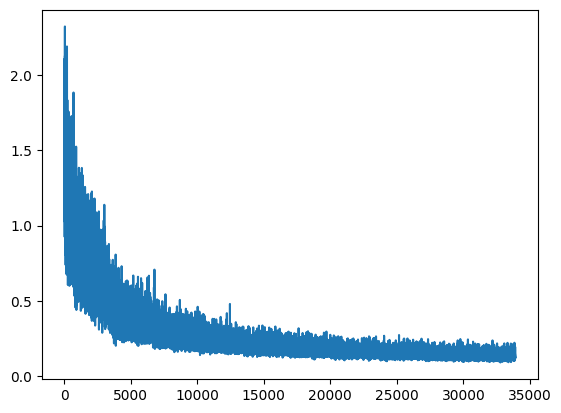

In [38]:
# initialize GloveDataset
# loads the text, tokenizes it, build the vocabulary, create co-occurrence matrix
dataset = GloveDataset(input_lang, output_lang, train_pairs)
# set embedding dimension to 50
EMBED_DIM = 50

# initialize the glove model with vocabulary size and embedding dimension
glove = GloveModel(dataset._vocab_len, EMBED_DIM).to(device)

# initializes the Adagrad optimizer with the model parameters, learning rate = 0.05
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)

#training
# number of training epochs
N_EPOCHS = 10
# batvh size
BATCH_SIZE = 500
# max value for weighting function normalization
X_MAX = 100
# exponent used in the weighting function
ALPHA = 0.75
# calculate the number of batches per epoch
n_batches = int(len(dataset._xij) / BATCH_SIZE)
# initializes an empty list to store the loss values
loss_values = list()

# iterates over number of epochs
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))

plt.plot(loss_values)
print("Saving model...")
torch.save(glove.state_dict(), "GloVe.pt")

In [39]:
pretrained_embeddings = glove.wi.weight.data

In [40]:
class EncoderRNN_m3(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, pretrained_embeddings=None):
        super(EncoderRNN_m3, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size

        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
            self.embedding = nn.Embedding(input_size, embedding_size)

        # Replace GRU with LSTM
        self.lstm = nn.LSTM(embedding_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        # Return both hidden state and cell state
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))


In [41]:
class AttnDecoderRNN_m3(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, pretrained_embeddings=None):
        super(AttnDecoderRNN_m3, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        else:
            self.embedding = nn.Embedding(output_size, embedding_size)

        self.attn = nn.Linear(self.hidden_size + self.embedding_size, max_length)
        self.attn_combine = nn.Linear(self.hidden_size + self.embedding_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)

        # Replace GRU with LSTM
        self.lstm = nn.LSTM(hidden_size, hidden_size)

        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        # Return both hidden state and cell state
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))


In [42]:
teacher_forcing_ratio = 1


def train_m3(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [43]:
def evaluate_m3(input_tensor, target_tensor, encoder, decoder, criterion, max_length=150):
    # Initialize hidden states
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Encoder processing
    for ei in range(min(input_length, max_length)):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Prepare for decoding
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    loss = 0

    # Decoder processing
    with torch.no_grad():
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    return loss.item() / target_length


In [44]:
def validate_model_m3(encoder, decoder, val_pairs, criterion, max_length=MAX_LENGTH, num_samples=300):
    # Randomly select a subset of validation pairs
    sampled_pairs = random.sample(val_pairs, num_samples) if len(val_pairs) > num_samples else val_pairs

    total_loss = 0
    with torch.no_grad():
        for input_tensor, target_tensor in sampled_pairs:
            loss = evaluate_m3(input_tensor, target_tensor, encoder, decoder, criterion, max_length)
            total_loss += loss

    average_loss = total_loss / len(sampled_pairs)
    return average_loss

In [45]:
def trainIters_m3(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    validation_pairs = [tensorsFromPair(random.choice(val_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_m3(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

            val_loss = validate_model_m3(encoder, decoder, validation_pairs, criterion)
            val_losses.append(val_loss)
            print(f'Validation Loss: {val_loss:.4f} at iteration {iter}')

    # showPlot(plot_losses)
    return plot_losses, val_losses

In [46]:
hidden_size = 256
encoder_m3 = EncoderRNN_m3(input_lang.n_words, EMBED_DIM, hidden_size, pretrained_embeddings=pretrained_embeddings).to(device)
decoder_m3 = AttnDecoderRNN_m3(EMBED_DIM, hidden_size, output_lang.n_words, pretrained_embeddings=pretrained_embeddings).to(device)
train_losses_m3, val_losses_m3 = trainIters_m3(encoder_m3, decoder_m3, 40000, print_every=500, plot_every=500)

0m 51s (- 67m 53s) (500 1%) 6.8338
Validation Loss: 7.0869 at iteration 500
1m 52s (- 72m 58s) (1000 2%) 5.9809
Validation Loss: 5.9415 at iteration 1000
2m 51s (- 73m 29s) (1500 3%) 5.6504
Validation Loss: 3.5177 at iteration 1500
3m 43s (- 70m 48s) (2000 5%) 5.3893
Validation Loss: 7.0276 at iteration 2000
4m 44s (- 71m 12s) (2500 6%) 5.2305
Validation Loss: 5.4754 at iteration 2500
5m 40s (- 70m 3s) (3000 7%) 4.9774
Validation Loss: 7.5884 at iteration 3000
6m 42s (- 69m 52s) (3500 8%) 4.8530
Validation Loss: 8.1912 at iteration 3500
7m 44s (- 69m 42s) (4000 10%) 4.7112
Validation Loss: 7.5652 at iteration 4000
8m 47s (- 69m 18s) (4500 11%) 4.6644
Validation Loss: 8.1024 at iteration 4500
9m 47s (- 68m 33s) (5000 12%) 4.5722
Validation Loss: 7.0250 at iteration 5000
10m 45s (- 67m 28s) (5500 13%) 4.5093
Validation Loss: 8.2394 at iteration 5500
11m 51s (- 67m 9s) (6000 15%) 4.4428
Validation Loss: 6.6786 at iteration 6000
12m 48s (- 66m 2s) (6500 16%) 4.3600
Validation Loss: 4.1338 

# Extend Model 2: Plug-and-Play Recipe Generation with Content Planning

In [47]:
import torch
import torch.nn as nn

class EncoderRNN_m4(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.1):
        # call the constructor of the parent class 'nn.model'
        super(EncoderRNN_m4, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # initialize embedding layer
        # this layer used to convert input into dense vectors of hidden size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # initialize th LSTM
        # num_layers: number of lstm layer in the network
        # droupour: input and recurrent connections within each lstm layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, dropout=dropout)

    def forward(self, input, hidden):
        # embeds the input tensor using the embedding layer
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        # pass embedded input and initial hidden stage through lstm layer
        output, (hidden, cell) = self.lstm(output, hidden)
        # return the output tensor and final hidden cell states from lstm layer
        return output, (hidden, cell)

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))

In [48]:
import torch.nn.functional as F
import torch

class AttnDecoderRNN_m4(nn.Module):
    def __init__(self, hidden_size, output_size, stage_size, num_layers=2, dropout_p=0.1, max_length=150):
        super(AttnDecoderRNN_m4, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # stage
        self.stage_embedding = nn.Embedding(stage_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=num_layers, dropout=dropout_p)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, cell, encoder_outputs, current_stage):
        embedded = self.embedding(input).view(1, 1, -1)
        # stage
        stage_embedded = self.stage_embedding(current_stage).view(1, 1, -1)
        combined_embedded = torch.cat((embedded, stage_embedded), 2)
        combined_embedded = self.dropout(combined_embedded)
        # embedded = self.dropout(embedded)

        lstm_output, (hidden, cell) = self.lstm(embedded, (hidden, cell))

        attn_weights = F.softmax(torch.bmm(lstm_output, encoder_outputs.unsqueeze(0).permute(0, 2, 1)), dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], lstm_output[0]), 1)
        output = F.log_softmax(self.out(concat_output), dim=1)

        return output, hidden, cell, attn_weights

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))

In [49]:
def criteria_for_next_stage(token):
    return token in ['.', ';']

In [50]:
from transformers import BartForConditionalGeneration, BartTokenizer, GPT2LMHeadModel, GPT2Tokenizer

# Load the content planner model and tokenizer
planner = BartForConditionalGeneration.from_pretrained('yinhongliu/recipe_with_plan_bart_planner').to(device)
planner_tokenizer = BartTokenizer.from_pretrained('yinhongliu/recipe_with_plan_bart_planner')

c:\Users\mirik\anaconda3\envs\NLP\Lib\site-packages\transformers\adapters\__init__.py:27: FutureWarning: The `adapter-transformers` package is deprecated and replaced by the `adapters` package. See https://docs.adapterhub.ml/transitioning.html.
  warnings.warn(


In [51]:
import torch
import random

teacher_forcing_ratio = 1

def train_m4(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, planner, planner_tokenizer, stage_vocab, max_length=150):
    # Initialize the hidden state and cell state of the encoder
    encoder_hidden, encoder_cell = encoder.initHidden()

    # Zero gradients for encoder and decoder
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Determine the length of the input and target sequence
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Initialize a tensor to hold encoder output
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Generate the content plan
    ingredients_text = " ".join([input_lang.index2word[token.item()] for token in input_tensor])
    inputs = planner_tokenizer(ingredients_text, return_tensors='pt', max_length=512, truncation=True).to(device)
    content_plan_output = planner.generate(**inputs)
    content_plan = planner_tokenizer.decode(content_plan_output[0], skip_special_tokens=True).split()

    # Debugging line to check the content plan output
    # print("Content Plan:", content_plan)

    content_plan_indices = [stage_vocab.get(stage, stage_vocab['<unk>']) for stage in content_plan]
    content_plan_tensor = torch.tensor(content_plan_indices, device=device)  # Convert to tensor

    loss = 0

    # Iterate over input sequence
    for ei in range(input_length):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(
            input_tensor[ei], (encoder_hidden, encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    # Initialize the decoder input with the start-of-sequence token
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # Initialize hidden and cell for decoder to the final hidden and cells states of the encoder
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    current_stage_index = 0
    current_stage = content_plan_tensor[current_stage_index].unsqueeze(0).unsqueeze(0)  # Correctly shaped tensor

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs, current_stage)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

            if criteria_for_next_stage(decoder_input):  # Define this function
                current_stage_index += 1
                if current_stage_index < len(content_plan_tensor):
                    current_stage = content_plan_tensor[current_stage_index].unsqueeze(0).unsqueeze(0)

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs, current_stage)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

            if criteria_for_next_stage(decoder_input):  # Define this function
                current_stage_index += 1
                if current_stage_index < len(content_plan_tensor):
                    current_stage = content_plan_tensor[current_stage_index].unsqueeze(0).unsqueeze(0)

    # Backpropagate the loss
    loss.backward()

    # Clip the gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)

    # Update the parameters of the encoder and decoder using their respective optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [52]:
def evaluate_m4(input_tensor, target_tensor, encoder, decoder, criterion, max_length=150):
    encoder_hidden, encoder_cell = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    ingredients_text = " ".join([input_lang.index2word[token.item()] for token in input_tensor])
    inputs = planner_tokenizer(ingredients_text, return_tensors='pt', max_length=512, truncation=True).to(device)
    content_plan_output = planner.generate(**inputs)
    content_plan = planner_tokenizer.decode(content_plan_output[0], skip_special_tokens=True).split()

    content_plan_indices = [stage_vocab.get(stage, stage_vocab['<unk>']) for stage in content_plan]
    content_plan_tensor = torch.tensor(content_plan_indices, device=device)  # Convert to tensor

    # Encoder
    for ei in range(input_length):
        # print(input_tensor[ei], encoder_hidden.size())
        # ==
        encoder_output, (encoder_hidden, encoder_cell) = encoder(
            input_tensor[ei], (encoder_hidden, encoder_cell))
        # ==
        if ei < max_length:
            encoder_outputs[ei] = encoder_output[0, 0]

    current_stage_index = 0
    current_stage = content_plan_tensor[current_stage_index].unsqueeze(0).unsqueeze(0)  # Correctly shaped tensor

    loss = 0

    # Decoder
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    for di in range(target_length):
        # ====
        decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs, current_stage)
        # ====
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # Use its own predictions as the next input
        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

In [53]:
def validate_model_m4(encoder, decoder, val_pairs, criterion, max_length=MAX_LENGTH, num_samples=300):
    # Randomly select a subset of validation pairs
    if len(val_pairs) > num_samples:
        sampled_pairs = random.sample(val_pairs, num_samples)
    else:
        sampled_pairs = val_pairs

    total_loss = 0
    with torch.no_grad():
        for input_tensor, target_tensor in sampled_pairs:
            loss = evaluate_m4(input_tensor, target_tensor, encoder, decoder, criterion, max_length)
            total_loss += loss

    average_loss = total_loss / len(sampled_pairs)
    return average_loss

In [54]:
from transformers import BartForConditionalGeneration, BartTokenizer, GPT2LMHeadModel, GPT2Tokenizer

def trainIters_m4(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # initialize adam optimizers for encoder and decoder
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # # Load the content planner model and tokenizer
    # planner = BartForConditionalGeneration.from_pretrained('yinhongliu/recipe_with_plan_bart_planner').to(device)
    # planner_tokenizer = BartTokenizer.from_pretrained('yinhongliu/recipe_with_plan_bart_planner')

    # create training pairs by randomly selecting pairs from dataset and convert them into tensors
    training_pairs = [tensorsFromPair(random.choice(train_pairs)) for _ in range(n_iters)]
    validation_pairs = [tensorsFromPair(random.choice(val_pairs))
                      for i in range(n_iters)]

    # Negative log likelihood loss criterion for training
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # call train_attn to compute loss for current iteration
        # loss = train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        loss = train_m4(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, planner, planner_tokenizer, stage_vocab)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

            val_loss = validate_model_m4(encoder, decoder, validation_pairs, criterion)
            val_losses.append(val_loss)
            print(f'Validation Loss: {val_loss:.4f} at iteration {iter}')

    # showPlot(plot_losses)
    return plot_losses, val_losses

In [55]:
hidden_size = 256

stage_vocab = {
    'pre-processing': 0,
    'mixing': 1,
    'cooking': 2,
    'post-processing': 3,
    'final': 4,
    '<unk>': 5  # Unknown token to handle any unexpected stages
}
stage_size = len(stage_vocab)

# input_lang.n_words: size of the vocabulary of the input language
encoder_m4 = EncoderRNN_m4(input_lang.n_words, hidden_size).to(device)
# dropout_p: dropoup probability, which help in regularization by randomly dropping connections during training
decoder_m4 = AttnDecoderRNN_m4(hidden_size, output_lang.n_words, stage_size=len(stage_vocab), dropout_p=0.1).to(device)
train_losses_m4, val_losses_m4 = trainIters_m4(encoder_m4, decoder_m4, 40000, print_every=500, plot_every=500)

c:\Users\mirik\anaconda3\envs\NLP\Lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


1m 46s (- 140m 34s) (500 1%) 5.4597
Validation Loss: 2.5831 at iteration 500
3m 52s (- 151m 16s) (1000 2%) 4.8968
Validation Loss: 7.7976 at iteration 1000
6m 7s (- 157m 11s) (1500 3%) 4.7299
Validation Loss: 5.1080 at iteration 1500
8m 18s (- 157m 58s) (2000 5%) 4.4976
Validation Loss: 7.6728 at iteration 2000
10m 36s (- 159m 9s) (2500 6%) 4.4361
Validation Loss: 6.1969 at iteration 2500
12m 48s (- 157m 59s) (3000 7%) 4.4136
Validation Loss: 8.1146 at iteration 3000
15m 4s (- 157m 9s) (3500 8%) 4.3612
Validation Loss: 8.0804 at iteration 3500
17m 17s (- 155m 40s) (4000 10%) 4.3583
Validation Loss: 7.2097 at iteration 4000
19m 31s (- 154m 3s) (4500 11%) 4.3685
Validation Loss: 7.6046 at iteration 4500
21m 45s (- 152m 21s) (5000 12%) 4.2155
Validation Loss: 5.3755 at iteration 5000
23m 56s (- 150m 13s) (5500 13%) 4.1474
Validation Loss: 5.5150 at iteration 5500
26m 6s (- 147m 54s) (6000 15%) 4.2309
Validation Loss: 4.5708 at iteration 6000
28m 15s (- 145m 36s) (6500 16%) 4.1867
Validati

# Plot

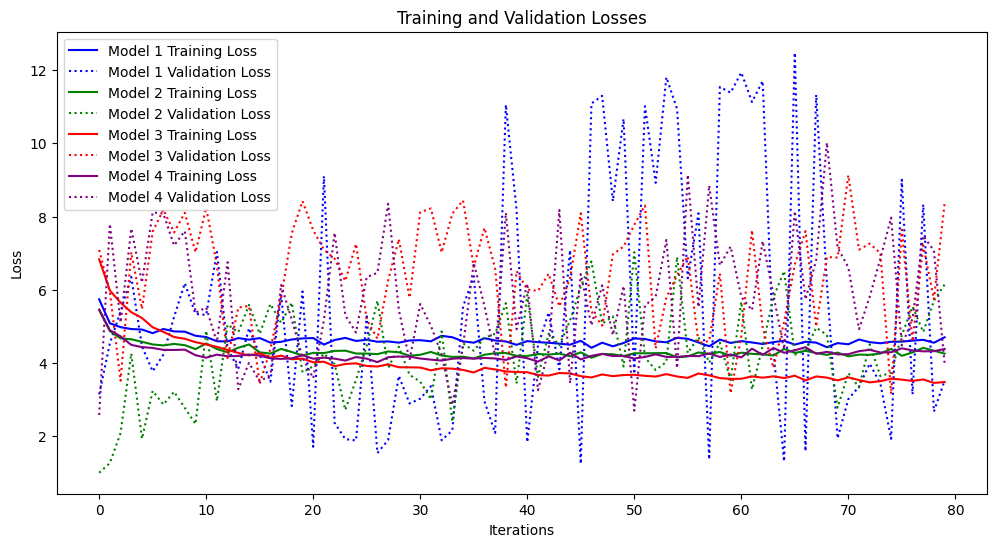

In [59]:
import matplotlib.pyplot as plt

def showPlot(all_train_losses, all_val_losses, colors, model_labels, title=None):
    plt.figure(figsize=(12, 6))

    # Check if the correct amount of data is provided
    if len(all_train_losses) != 4 or len(all_val_losses) != 4 or len(colors) != 4 or len(model_labels) != 4:
        raise ValueError("Ensure there are exactly four models' losses, colors, and labels provided.")

    # Plot each model's training and validation loss
    for train_losses, val_losses, color, label in zip(all_train_losses, all_val_losses, colors, model_labels):
        plt.plot(train_losses, color=color, label=f'{label} Training Loss', linestyle='solid')
        plt.plot(val_losses, color=color, label=f'{label} Validation Loss', linestyle='dotted')

    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title if title else 'Training and Validation Losses')
    plt.legend()
    plt.show()

# Example data for testing the function
train_losses_model1 = train_losses
val_losses_model1 = val_losses
train_losses_model2 = train_losses_m2
val_losses_model2 = val_losses_m2
train_losses_model3 = train_losses_m3
val_losses_model3 = val_losses_m3
train_losses_model4 = train_losses_m4
val_losses_model4 = val_losses_m4        

colors = ['blue', 'green', 'red', 'purple']  # Different colors for each model
labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4']  # Labels for each model

# Calling the function with the test data
showPlot([train_losses_model1, train_losses_model2, train_losses_model3, train_losses_model4],
         [val_losses_model1, val_losses_model2, val_losses_model3, val_losses_model4],
         colors, labels)

# Predict Functions

In [60]:
def predict_m1(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Encode each input tensor and update hidden states
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
            if ei < max_length:
                encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # Start with SOS
        decoder_hidden = encoder_hidden  # Pass the encoder's final hidden state to the decoder

        decoded_words = []
        # decoder_attentions = torch.zeros(max_length, max_length)  # If attention is not used, this can be omitted

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


In [61]:
def predict_m2(encoder, decoder, sentence, max_length=150):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], (encoder_hidden, encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [62]:
def predict_m3(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [63]:
def predict_m4(encoder, decoder, sentence, planner, planner_tokenizer, stage_vocab, max_length=150):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei], (encoder_hidden, encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        # Generate the content plan
        ingredients_text = sentence
        inputs = planner_tokenizer(ingredients_text, return_tensors='pt', max_length=512, truncation=True).to(device)
        content_plan_output = planner.generate(**inputs)
        content_plan = planner_tokenizer.decode(content_plan_output[0], skip_special_tokens=True).split()
        # print("Generated Content Plan:", content_plan)
        content_plan_indices = [stage_vocab.get(stage, stage_vocab['<unk>']) for stage in content_plan]
        content_plan_tensor = torch.tensor(content_plan_indices, device=device)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        current_stage_index = 0
        current_stage = content_plan_tensor[current_stage_index].unsqueeze(0).unsqueeze(0)  # Correctly shaped tensor

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs, current_stage)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

            if criteria_for_next_stage(decoder_input):  # Define this function
                current_stage_index += 1
                if current_stage_index < len(content_plan_tensor):
                    current_stage = content_plan_tensor[current_stage_index].unsqueeze(0).unsqueeze(0)

        return decoded_words, decoder_attentions[:di + 1]

# Quantitative Evaluation

In [64]:
pip install pandas nltk

Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate import bleu_score, meteor_score
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mirik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mirik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [74]:
def quantitative_analysis(test_pairs, models, model_functions):
    results = {
        'Model 1': {'BLEU-4': [], 'METEOR': [], 'Avg. % Given Items': [], 'Avg. Extra Items': []},
        'Model 2': {'BLEU-4': [], 'METEOR': [], 'Avg. % Given Items': [], 'Avg. Extra Items': []},
        'Model 3': {'BLEU-4': [], 'METEOR': [], 'Avg. % Given Items': [], 'Avg. Extra Items': []},
        'Model 4': {'BLEU-4': [], 'METEOR': [], 'Avg. % Given Items': [], 'Avg. Extra Items': []}
    }

    # Iterate over all the test pairs
    for idx, (ingredient, reference) in enumerate(test_pairs):
        reference_tokens = nltk.word_tokenize(reference.lower())

        for model_index, model in enumerate(models):
            # Select the appropriate prediction function and arguments
            if model_index == 0:  # Model 1
                output_words = model_functions[model_index](model[0], model[1], ingredient)
            elif model_index == 1:  # Model 2
                output_words, attention = model_functions[model_index](model[0], model[1], ingredient)
            elif model_index == 2:  # Model 3
                output_words, attention = model_functions[model_index](model[0], model[1], ingredient)
            elif model_index == 3:  # Model 4
                output_words, attention = model_functions[model_index](model[0], model[1], ingredient, planner, planner_tokenizer, stage_vocab)

            output_sentence = ' '.join(output_words)
            pred_tokens = nltk.word_tokenize(output_sentence.lower())

            # Calculate BLEU-4 and METEOR
            bleu = bleu_score.sentence_bleu([reference_tokens], pred_tokens, smoothing_function=bleu_score.SmoothingFunction().method1)
            meteor = meteor_score.single_meteor_score(reference_tokens, pred_tokens)  # Use tokenized reference and prediction

            # Calculate Avg. % Given Items and Avg. Extra Items
            ref_set = set(reference_tokens)
            pred_set = set(pred_tokens)
            avg_given_items = 100 * len(ref_set & pred_set) / len(ref_set) if ref_set else 0
            avg_extra_items = len(pred_set - ref_set)

            # Append results
            model_name = f'Model {model_index + 1}'
            results[model_name]['BLEU-4'].append(bleu)
            results[model_name]['METEOR'].append(meteor)
            results[model_name]['Avg. % Given Items'].append(avg_given_items)
            results[model_name]['Avg. Extra Items'].append(avg_extra_items)

    # Average the results for each metric
    for model_result in results.values():
        for key in model_result:
            model_result[key] = sum(model_result[key]) / len(model_result[key]) if model_result[key] else 0

    return results

In [75]:
models = [(encoder_m1, decoder_m1), (encoder_m2, decoder_m2), (encoder_m3, decoder_m3), (encoder_m4, decoder_m4)]
model_functions = [predict_m1, predict_m2, predict_m3, predict_m4]
results = quantitative_analysis(test_pairs, models, model_functions)
# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

                      Model 1    Model 2    Model 3   Model 4
BLEU-4               0.008282   0.007393   0.011448  0.005452
METEOR               0.080962   0.083673   0.135333  0.061210
Avg. % Given Items  12.096125  11.994506  18.125431  9.076380
Avg. Extra Items     9.489231   6.398462  17.435385  7.850769


In [67]:
def read_recipes_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Assuming structure: even lines after titles are ingredients and recipes
    gold_recipe = lines[4].strip()  # Adjust line numbers based on actual structure
    generated_recipe = lines[7].strip()

    return gold_recipe, generated_recipe

In [68]:
from nltk.tokenize import word_tokenize

def extract_ingredients(tokens):
    ingredients = []
    capture = False
    current_ingredient = []

    for token in tokens:
        if token == '<':
            capture = True
            current_ingredient = []
        elif token == '>':
            if current_ingredient:
                ingredients.append(''.join(current_ingredient))
            capture = False
        elif capture:
            current_ingredient.append(token)

    return set(ingredients)

def calculate_metrics(gold_recipe, generated_recipe):
    # Tokenize the recipes
    gold_tokens = word_tokenize(gold_recipe.lower())
    generated_tokens = word_tokenize(generated_recipe.lower())
    # print(gold_tokens)
    # print(generated_tokens)

    # Extract ingredients using the new method
    gold_ingredients = extract_ingredients(gold_tokens)
    generated_ingredients = extract_ingredients(generated_tokens)

    # Calculate BLEU-4
    bleu_score_value = bleu_score.sentence_bleu([gold_tokens], generated_tokens, smoothing_function=bleu_score.SmoothingFunction().method1)

    # Calculate METEOR
    meteor_score_value = meteor_score.single_meteor_score(gold_tokens, generated_tokens)

    # Calculate Average Percentage of Given Items
    common_ingredients = gold_ingredients.intersection(generated_ingredients)
    avg_given_items = 100 * len(common_ingredients) / len(gold_ingredients) if gold_ingredients else 0

    # Calculate Average Extra Items
    avg_extra_items = len(generated_ingredients - gold_ingredients)

    return bleu_score_value, meteor_score_value, avg_given_items, avg_extra_items

In [69]:
# File path to the text file
metric_sample_file_path = file_path + 'metric_sample.txt'

gold_recipe, generated_recipe = read_recipes_from_file(metric_sample_file_path)

bleu, meteor, avg_given, avg_extra = calculate_metrics(gold_recipe, generated_recipe)

print(f"BLEU-4 Score: {bleu:.4f}")
print(f"METEOR Score: {meteor:.4f}")
print(f"Avg. % Given Items: {avg_given:.2f}%")
print(f"Avg. Extra Items: {avg_extra}")

BLEU-4 Score: 0.2757
METEOR Score: 0.5479
Avg. % Given Items: 100.00%
Avg. Extra Items: 2


# Qualitative Evaluation

In [71]:
# Load the existing CSV file
generated_file_path = file_path +  "generated_31044891.csv"
generated_data = pd.read_csv(generated_file_path)
generated_data['Ingredients'] = generated_data['Ingredients'].apply(normalizeString)

In [72]:
import pandas as pd

def generate(encoder, decoder, model, ingredients, generated_data):
    """Evaluates the encoder and decoder models by processing each ingredient and updates the DataFrame accordingly."""
    # Define column names based on the model number
    column_names = {
        1: "Generated Recipe - Baseline 1",
        2: "Generated Recipe - Baseline 2",
        3: "Generated Recipe - Extended 1",
        4: "Generated Recipe - Extended 2"
    }
    column_name = column_names[model]

    # Ensure the column exists in the DataFrame
    if column_name not in generated_data.columns:
        generated_data[column_name] = pd.Series([None] * len(generated_data), index=generated_data.index)

    # Generate predictions for each ingredient
    predictions = []
    for idx, ingredient in enumerate(ingredients):
        # Determine which model evaluation function to call
        if model == 1:
            output_words = predict_m1(encoder, decoder, ingredient)
        elif model == 2:
            output_words, attention = predict_m2(encoder, decoder, ingredient)
        elif model == 3:
            output_words, attention = predict_m3(encoder, decoder, ingredient)
        elif model == 4:
            output_words, attention = predict_m4(encoder, decoder, ingredient, planner, planner_tokenizer, stage_vocab)

        output_sentence = ' '.join(output_words)
        predictions.append(output_sentence)

        # Assign predictions to the DataFrame
        generated_data.at[idx, column_name] = output_sentence

    return generated_data

# Extract ingredients for prediction
ingredients = generated_data['Ingredients'].tolist()

# Predict recipes for each model and update the CSV file
for model in range(1, 5):
    encoder = globals()[f'encoder_m{model}']
    decoder = globals()[f'decoder_m{model}']
    generated_data = generate(encoder, decoder, model, ingredients, generated_data)

# Save the updated DataFrame to the same CSV file
generated_data.to_csv(generated_file_path, index=False)

print("Recipe prediction and data saving completed.")

C:\Users\mirik\AppData\Local\Temp\ipykernel_33872\3864532078.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'combine all ingredients in a large bowl . add the remaining ingredients . add the chicken . <EOS>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  generated_data.at[idx, column_name] = output_sentence
C:\Users\mirik\AppData\Local\Temp\ipykernel_33872\3864532078.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'beat eggs and salt together . beat until smooth . beat until smooth . beat until smooth . beat until smooth . beat until smooth . beat until smooth . beat until smooth . beat until smooth . beat until smooth . beat until smooth . beat egg whites until smooth . beat until smooth . beat until smooth . beat until smooth . beat until smooth . beat until smooth . b

Recipe prediction and data saving completed.


In [80]:
train_losses_m1 = train_losses 
val_losses_m1 = val_losses


In [81]:
def generate(encoder, decoder, model, ingredients):
    """Evaluates the encoder and decoder models by processing given ingredients and prints the generated recipe."""
    # Determine which model evaluation function to call
    if model == 1:
        output_words = predict_m1(encoder, decoder, ingredients)
        model_name = "Baseline 1"
    elif model == 2:
        output_words, attention = predict_m2(encoder, decoder, ingredients)
        model_name = "Baseline 2"
    elif model == 3:
        output_words, attention = predict_m3(encoder, decoder, ingredients)
        model_name = "Extension 1"
    elif model == 4:
        output_words, attention = predict_m4(encoder, decoder, ingredients, planner, planner_tokenizer, stage_vocab)
        model_name = "Extension 2"

    output_sentence = ' '.join(output_words)

    # Print the model and the corresponding generated recipe
    print(f"{model_name} Generated Recipe: {output_sentence}\n")

# Sample ingredient input
ingredients = "2 c sugar, 1/4 c lemon juice, 1 c water, 1/3 c orange juice, 8 c strawberries"

# Predict recipes for each model and print them
for model in range(1, 5):
    encoder = globals()[f'encoder_m{model}']
    decoder = globals()[f'decoder_m{model}']
    generate(encoder, decoder, model, ingredients)


Baseline 1 Generated Recipe: combine all ingredients in a large bowl . add the onion and garlic . add the onion and garlic . <EOS>

Baseline 2 Generated Recipe: combine all ingredients in a saucepan . <EOS>

Extension 1 Generated Recipe: combine the sugar and salt . add the milk and beat until well blended . add the dry ingredients and beat well . add the dry ingredients and beat well . add the dry ingredients and beat well . add the dry ingredients and beat well . add the dry ingredients and beat well . add the dry ingredients and beat until well blended . add the flour and salt and beat until well blended . add the dry ingredients and beat well . add the milk and beat until well blended . add the milk and beat until well blended . add the milk and beat until well blended . add the milk and beat until well blended . add the milk and beat until well blended . add the milk and beat until well blended . add the milk and beat until well blended . add the dry

Extension 2 Generated Recipe:

c:\Users\mirik\anaconda3\envs\NLP\Lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
